# readme
descrip: plot total, mean and eddy fluxes <br> 

update history: <br>
v1.0 DL 2021Feb06 <br>
v1.1 DL 2021Mar03 <br>
v1.2 DL 2021Apr24 <br>
v1.3 DL 2021May06 make publication-ready pics <br>
v1.4 DL 2021May20 combine TR run results into one fig (for main text) and control run results into one fig (support info) <br>
v1.5 DL 2021Jun02 pivot to CESM-HR special volume paper, use TR minus CN to account for the model drift <br>
 
extra notes: <br>
steps: <br>
1. finalize UET+VNT depth integration plot
2. interp temp from T grids to U grids 
3. compute 

# import modules

In [1]:
# general python packages
import numpy as np
# from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
%matplotlib inline
import proplot as plot
import cartopy
# import cartopy.crs as ccrs
cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
# from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid
import glob

# python GCM(POP) packages
import xgcm
import pop_tools
# import xoak
# import xesmf as xe

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
# from itertools import product
# from cftime import DatetimeNoLeap

from tqdm import tqdm

# incorporate dask 

In [2]:
client = Client("tcp://10.73.1.44:36773")
client

<Client: 'tcp://10.73.1.44:36773' processes=16 threads=16, memory=316.64 GiB>

# define parameters

In [3]:
# === r: region (US east coast excluding Gulf of Mexico) ===
# reference: Plot2FindGulfMexicoYucatanChannelFLstraitnlatnlonIndex_2021Jul20.ipynb
nlon1_r_t12, nlon2_r_t12 = 200+50, 700-50 
nlat1_r_t12, nlat2_r_t12 = 1300+100, 2000-100

nlon1_r_g16, nlon2_r_g16 = 260+10, 321
nlat1_r_g16, nlat2_r_g16 = 230+20, 350

lon1_r, lon2_r = -85, -50
lat1_r, lat2_r = 25, 55

chunks_HR = {'nlat':400,'nlon':300}
# chunks_LR = {'nlat':384,'nlon':320,'z_t':1}
chunks_LR = {'nlat':384,'nlon':320/5,'z_t':1}
# ===========================================================

In [4]:
# read TH UET, VNT 

# --- read one file ---
infile0_uet_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UET/'
                 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.UET.195001-195012.nc')
ds0_uet_TH = xr.open_dataset(infile0_uet_TH, chunks=chunks_HR)

# infile_vnt_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VNT/'
#                  'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.VNT.195001-195012.nc')

# ds_vnt_TH = xr.open_dataset(infile_vnt_TH, chunks=chunks_HR)
# ds_vnt_r_TH = ds_vnt_TH.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), nlat=slice(nlat1_r_t12, nlat2_r_t12))
# ds_vnt_r_TH.VNT.isel(time=0,z_t=0).where(ds_vnt_r_TH.KMT>0).plot()
# ds_vnt_TH 
# ---------------------


# example file: 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_TH = np.arange(2001,2005+1) 
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_uet_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/workp/')
infiles1a_uet_TH = [indir1a_uet_TH + prefix1a_TH + 'UET.' + str(iyr) + '.nc' 
               for iyr in yrs1a_TH]
infiles1a_uet_TH

indir1a_vnt_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/workp/')
infiles1a_vnt_TH = [indir1a_vnt_TH + prefix1a_TH + 'VNT.' + str(iyr) + '.nc' 
               for iyr in yrs1a_TH]
infiles1a_vnt_TH


yrs2_TH = np.arange(2006,2100+1)
prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_uet_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/workp/')
infiles2_uet_TH = [indir1b_uet_TH + prefix2_TH + 'UET.' + str(iyr) + '.nc' 
               for iyr in yrs2_TH]
infiles2_uet_TH

indir1b_vnt_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/workp/')
infiles2_vnt_TH = [indir1b_vnt_TH + prefix2_TH + 'VNT.' + str(iyr) + '.nc' 
               for iyr in yrs2_TH]
infiles2_vnt_TH


ds_uet_TH = xr.open_mfdataset(infiles1a_uet_TH + infiles2_uet_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

ds_vnt_TH = xr.open_mfdataset(infiles1a_vnt_TH + infiles2_vnt_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_vnt_TH first time: ', ds_vnt_TH.time[0].values)
print('ds_vnt_TH end time: ', ds_vnt_TH.time[-1].values)
print('ds_vnt_TH # time: ', len(ds_vnt_TH.time))
#ds_vnt_TH

ds_vnt_TH first time:  2001-07-01 15:16:21.818181
ds_vnt_TH end time:  2100-07-01 15:16:21.818181
ds_vnt_TH # time:  100


In [5]:
# read TH UES, VNS 

# --- read one file ---
# infile_ues_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UES/'
#                  'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.UES.195001-195012.nc')
# chunks_HR = {'nlat':400,'nlon':300,'z_t':1}
# ds_ues_TH = xr.open_dataset(infile_ues_TH, chunks=chunks_HR)
# ds_ues_r_TH = ds_ues_TH.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), nlat=slice(nlat1_r_t12, nlat2_r_t12))
# ds_ues_r_TH.UES.isel(time=0,z_t=0).where(ds_ues_r_TH.KMT>0).plot()
# ds_ues_TH 

# infile_vns_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VNS/'
#                  'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.VNS.195001-195012.nc')

# ds_vns_TH = xr.open_dataset(infile_vns_TH, chunks=chunks_HR)
# ds_vns_r_TH = ds_vns_TH.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), nlat=slice(nlat1_r_t12, nlat2_r_t12))
# ds_vns_r_TH.VNS.isel(time=0,z_t=0).where(ds_vns_r_TH.KMT>0).plot()
# ds_vns_TH 
# ---------------------


# example file: 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_TH = np.arange(2001,2005+1) 
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_ues_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/workp/')
infiles1a_ues_TH = [indir1a_ues_TH + prefix1a_TH + 'UES.' + str(iyr) + '.nc' 
               for iyr in yrs1a_TH]
infiles1a_ues_TH

indir1a_vns_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/workp/')
infiles1a_vns_TH = [indir1a_vns_TH + prefix1a_TH + 'VNS.' + str(iyr) + '.nc' 
               for iyr in yrs1a_TH]
infiles1a_vns_TH


yrs2_TH = np.arange(2006,2100+1)
prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_ues_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/workp/')
infiles2_ues_TH = [indir1b_ues_TH + prefix2_TH + 'UES.' + str(iyr) + '.nc' 
               for iyr in yrs2_TH]
infiles2_ues_TH

indir1b_vns_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/workp/')
infiles2_vns_TH = [indir1b_vns_TH + prefix2_TH + 'VNS.' + str(iyr) + '.nc' 
               for iyr in yrs2_TH]
infiles2_vns_TH


ds_ues_TH = xr.open_mfdataset(infiles1a_ues_TH + infiles2_ues_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

ds_vns_TH = xr.open_mfdataset(infiles1a_vns_TH + infiles2_vns_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_vns_TH first time: ', ds_vns_TH.time[0].values)
print('ds_vns_TH end time: ', ds_vns_TH.time[-1].values)
print('ds_vns_TH # time: ', len(ds_vns_TH.time))
#ds_vns_TH

ds_vns_TH first time:  2001-07-01 15:16:21.818181
ds_vns_TH end time:  2100-07-01 15:16:21.818181
ds_vns_TH # time:  100


In [6]:
# supplimentary files 

# infile_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
#               'POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
# ds_t12 = xr.open_dataset(infile_t12)
# ds_t12

infile_3dDZT_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
                    '3dDZT_SY_2021Nov04.nc') 
ds_3dDZT_t12 = xr.open_dataset(infile_3dDZT_t12)
ds_3dDZT_t12

infile_3dDZU_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
                    '3dDZU_SY_2021Nov04.nc') 
ds_3dDZU_t12 = xr.open_dataset(infile_3dDZU_t12)
ds_3dDZU_t12
# ds_r_t12 = ds_t12.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
#                        nlat=slice(nlat1_r_t12, nlat2_r_t12))

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, z_t: 62)
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    DZU      (z_t, nlat, nlon) float64 ...

# data analysis

In [7]:
# make TH time coordinate consistent across different ds, otherwise xarray data array subtraction does not work 
print(ds_uet_TH.time[0].values, ds_uet_TH.time[-1].values, len(ds_uet_TH.time)) 
print(ds_vnt_TH.time[0].values, ds_vnt_TH.time[-1].values, len(ds_vnt_TH.time)) 
print(ds_ues_TH.time[0].values, ds_ues_TH.time[-1].values, len(ds_ues_TH.time)) 
print(ds_vns_TH.time[0].values, ds_vns_TH.time[-1].values, len(ds_vns_TH.time)) 

time_uet_s_TH = ds_uet_TH.time.to_pandas().index.shift(-1,'D') # shift it one month back 
# ds_uet_TH = ds_uet_TH_raw.assign_coords(time=time_hdift_s_TL).sel(time=slice('2001','2100'))

# ds_hdift_TL = ds_hdift_TL.assign_coords(time=ds_uet_TL.time)
# ds_hdifs_TL = ds_hdifs_TL.assign_coords(time=ds_uet_TL.time)
ds_uet_TH = ds_uet_TH.assign_coords(time=time_uet_s_TH)
ds_vnt_TH = ds_vnt_TH.assign_coords(time=time_uet_s_TH)
ds_ues_TH = ds_ues_TH.assign_coords(time=time_uet_s_TH)
ds_vns_TH = ds_vns_TH.assign_coords(time=time_uet_s_TH)

2001-07-01 15:16:21.818181 2100-07-01 15:16:21.818181 100
2001-07-01 15:16:21.818181 2100-07-01 15:16:21.818181 100
2001-07-01 15:16:21.818181 2100-07-01 15:16:21.818181 100
2001-07-01 15:16:21.818181 2100-07-01 15:16:21.818181 100


In [8]:
%%time
ds_uet_TH["VNT"] = ds_vnt_TH.VNT
ds_uet_TH["UES"] = ds_ues_TH.UES
ds_uet_TH["VNS"] = ds_vns_TH.VNS
ds_uet_TH["DXT"] = ds0_uet_TH.DXT
ds_uet_TH["DXU"] = ds0_uet_TH.DXU
ds_uet_TH["DYT"] = ds0_uet_TH.DYT
ds_uet_TH["DYU"] = ds0_uet_TH.DYU
ds_uet_TH["TAREA"] = ds0_uet_TH.TAREA
ds_uet_TH["UAREA"] = ds0_uet_TH.UAREA
ds_uet_TH["KMT"] = ds0_uet_TH.KMT
ds_uet_TH["KMU"] = ds0_uet_TH.KMU
ds_uet_TH["DZU"] = ds_3dDZU_t12.DZU*100 # cm
ds_uet_TH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
ds_uet_TH.DZT.attrs["long_name"] = "Thickness of T cells"
ds_uet_TH.DZT.attrs["units"] = "centimeter"
ds_uet_TH.DZT.attrs["grid_loc"] = "3111"
ds_uet_TH.DZU.attrs["long_name"] = "Thickness of U cells"
ds_uet_TH.DZU.attrs["units"] = "centimeter"
ds_uet_TH.DZU.attrs["grid_loc"] = "3221"

# ds_hdift_r_TL = ds_hdift_TL.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), nlat=slice(nlat1_r_g16, nlat2_r_g16))
ds_uet_r_TH = ds_uet_TH.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), nlat=slice(nlat1_r_t12, nlat2_r_t12))

# ds_hdift_tre_r_TL = ds_hdift_TL.resample(time='A').mean('time')
# ds_uet_tre_r_TL = ds_uet_TL.resample(time='A').mean('time')
ds_uet_r_TH

print('loop start')
# make sure we have the cell volumne for calculations
VOL = (ds_uet_r_TH.DZT * ds_uet_r_TH.DXT * ds_uet_r_TH.DYT).compute()
KMT = ds_uet_r_TH.KMT.compute()

for j in tqdm(range(len(KMT.nlat))):
    for i in range(len(KMT.nlon)):
        k = KMT.values[j, i].astype(int)
        VOL.values[k:, j, i] = 0.0

ds_uet_r_TH["VOL"] = VOL

ds_uet_r_TH.VOL.attrs["long_name"] = "volume of T cells"
ds_uet_r_TH.VOL.attrs["units"] = "centimeter^3"

ds_uet_r_TH.VOL.attrs["grid_loc"] = "3111"

loop start


100%|██████████| 500/500 [00:00<00:00, 792.03it/s]

CPU times: user 2.03 s, sys: 4.88 s, total: 6.91 s
Wall time: 9.27 s


In [9]:
%%time
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],}


grid_uet_r_TH, xds_uet_r_TH = pop_tools.to_xgcm_grid_dataset(ds_uet_r_TH, 
                                                             periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)


for coord in ["nlat", "nlon"]:
    if coord in xds_uet_r_TH.coords:
        xds_uet_r_TH = xds_uet_r_TH.drop_vars(coord)
        
xds_uet_r_TH

CPU times: user 75.2 ms, sys: 1.48 ms, total: 76.7 ms
Wall time: 73.2 ms


<xarray.Dataset>
Dimensions:     (d2: 2, nlat_t: 500, nlat_u: 500, nlon_t: 400, nlon_u: 400, time: 100, z_t: 62)
Coordinates:
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG       (nlat_u, nlon_u) float64 dask.array<chunksize=(200, 50), meta=np.ndarray>
    TLAT        (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 50), meta=np.ndarray>
  * time        (time) object 2001-06-30 15:16:21.818181 ... 2100-06-30 15:16...
    ULAT        (nlat_u, nlon_u) float64 dask.array<chunksize=(200, 50), meta=np.ndarray>
    TLONG       (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 50), meta=np.ndarray>
  * nlon_u      (nlon_u) int64 1 2 3 4 5 6 7 8 ... 394 395 396 397 398 399 400
  * nlat_u      (nlat_u) int64 1 2 3 4 5 6 7 8 ... 494 495 496 497 498 499 500
  * nlon_t      (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 396.5 397.5 398.5 399.5
  * nlat_t      (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 496.5 497.5 498.5 499.5
Dimensions without coordinates: d2
Data variables: (12/16)
    time_bound  (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    UET         (time, z_t, nlat_t, nlon_u) float32 dask.array<chunksize=(1, 62, 200, 50), meta=np.ndarray>
    VNT         (time, z_t, nlat_u, nlon_t) float32 dask.array<chunksize=(1, 62, 200, 50), meta=np.ndarray>
    UES         (time, z_t, nlat_t, nlon_u) float32 dask.array<chunksize=(1, 62, 200, 50), meta=np.ndarray>
    VNS         (time, z_t, nlat_u, nlon_t) float32 dask.array<chunksize=(1, 62, 200, 50), meta=np.ndarray>
    DXT         (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 50), meta=np.ndarray>
    ...          ...
    UAREA       (nlat_u, nlon_u) float64 dask.array<chunksize=(200, 50), meta=np.ndarray>
    KMT         (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 50), meta=np.ndarray>
    KMU         (nlat_u, nlon_u) float64 dask.array<chunksize=(200, 50), meta=np.ndarray>
    DZU         (z_t, nlat_u, nlon_u) float64 1e+03 1e+03 1e+03 ... nan nan nan
    DZT         (z_t, nlat_t, nlon_t) float64 1e+03 1e+03 1e+03 ... nan nan nan
    VOL         (z_t, nlat_t, nlon_t) float64 1.073e+15 1.073e+15 ... 0.0 0.0
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Mon Jan 24 17:54:25 2022: ncra -v UET -d time,2001-01-01,2...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-03-16 at 08:33:13.4
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  34411091
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.9.7 (Homepage = http://nco.sf.n...

In [10]:
xds_uet_r_TH.UET # [degC/s]
print(xds_uet_r_TH.UET.dims) # 'nlat_t', 'nlon_u'
print(xds_uet_r_TH.UET.resample(time='A').mean('time').dims) # 'nlat_t', 'nlon_u'
grid_uet_r_TH.diff(xds_uet_r_TH.UET, axis="X").dims

('time', 'z_t', 'nlat_t', 'nlon_u')
('time', 'z_t', 'nlat_t', 'nlon_u')


('time', 'z_t', 'nlat_t', 'nlon_t')

In [11]:
uet_tre_r_TH = xds_uet_r_TH.UET#.resample(time='A').mean('time')
vnt_tre_r_TH = xds_uet_r_TH.VNT#.resample(time='A').mean('time')
ues_tre_r_TH = xds_uet_r_TH.UES
vns_tre_r_TH = xds_uet_r_TH.VNS
uet_tre_r_TH

,Array,Chunk
Bytes,4.62 GiB,21.29 MiB
Shape,"(100, 62, 500, 400)","(1, 62, 300, 300)"
Count,15100 Tasks,600 Chunks
Type,float32,numpy.ndarray


In [12]:
duet_tre_r_TH = -(grid_uet_r_TH.diff(uet_tre_r_TH * xds_uet_r_TH.VOL.values, axis="X") / xds_uet_r_TH.VOL)
dvnt_tre_r_TH = -(grid_uet_r_TH.diff(vnt_tre_r_TH * xds_uet_r_TH.VOL.values, axis="Y") / xds_uet_r_TH.VOL)
hdivt_tre_r_TH = (duet_tre_r_TH + dvnt_tre_r_TH)

dues_tre_r_TH = -(grid_uet_r_TH.diff(ues_tre_r_TH * xds_uet_r_TH.VOL.values, axis="X") / xds_uet_r_TH.VOL)
dvns_tre_r_TH = -(grid_uet_r_TH.diff(vns_tre_r_TH * xds_uet_r_TH.VOL.values, axis="Y") / xds_uet_r_TH.VOL)
hdivs_tre_r_TH = (dues_tre_r_TH + dvns_tre_r_TH)

hdivt_tre_r_TH 

<xarray.DataArray (time: 100, z_t: 62, nlat_t: 500, nlon_t: 400)>
dask.array<add, shape=(100, 62, 500, 400), dtype=float64, chunksize=(1, 62, 299, 299), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-06-30 15:16:21.818181 ... 2100-06-30 15:16:21...
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 496.5 497.5 498.5 499.5
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 396.5 397.5 398.5 399.5
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 50), meta=np.ndarray>
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 50), meta=np.ndarray>

<xarray.DataArray (time: 100, nlat_t: 500, nlon_t: 400)>
dask.array<sum-aggregate, shape=(100, 500, 400), dtype=float64, chunksize=(1, 299, 299), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-06-30 15:16:21.818181 ... 2100-06-30 15:16:21...
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 496.5 497.5 498.5 499.5
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 396.5 397.5 398.5 399.5
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 50), meta=np.ndarray>
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 50), meta=np.ndarray>

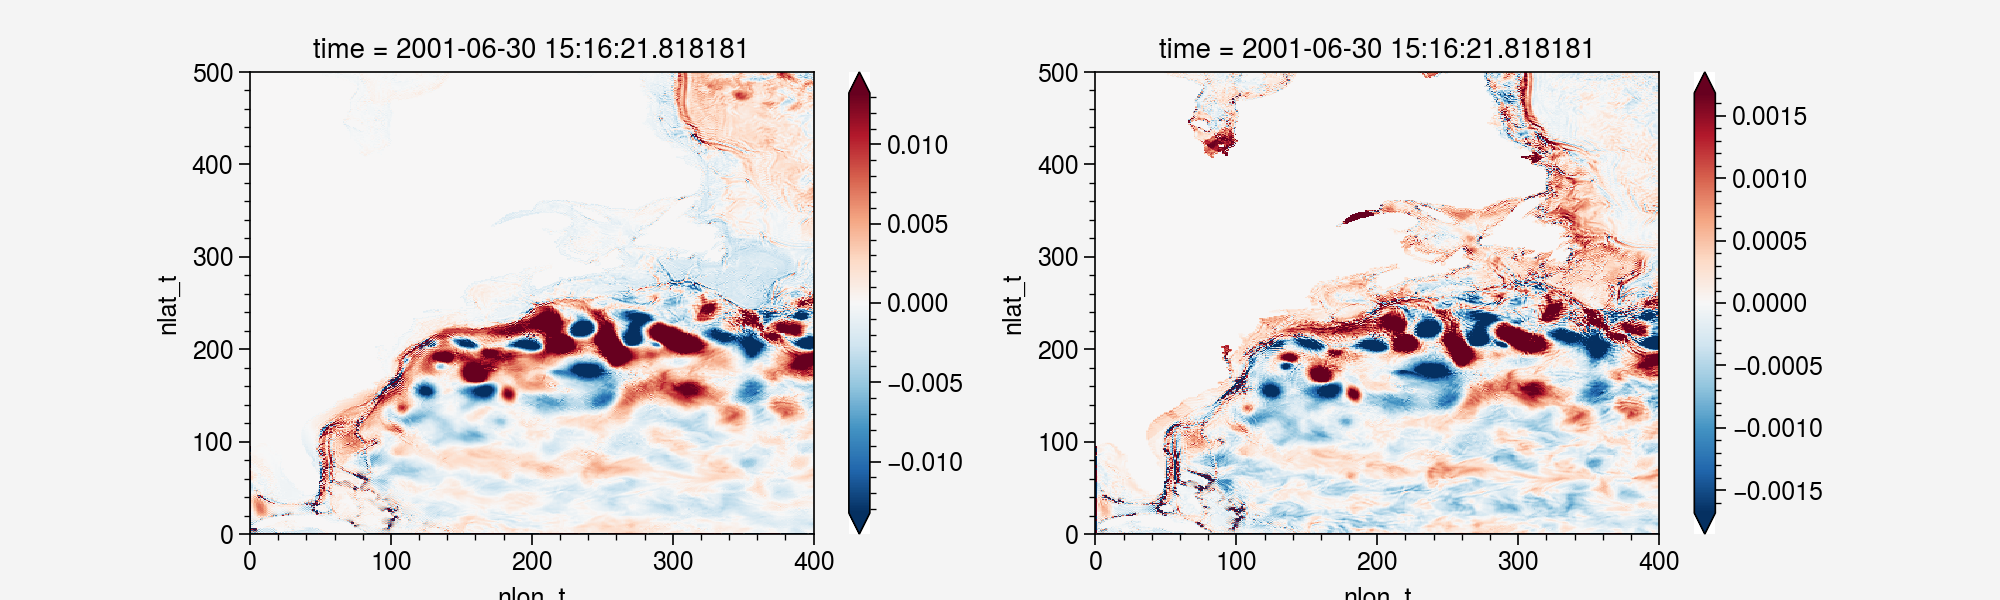

In [13]:
hdivt_tre_intz_r_TH = (hdivt_tre_r_TH*xds_uet_r_TH.DZT).sum('z_t') # [degC/s*cm]
hdivs_tre_intz_r_TH = (hdivs_tre_r_TH*xds_uet_r_TH.DZT).sum('z_t') # [psu/s*cm]

fig, axs = plt.subplots(1,2,figsize=(10,3))
hdivt_tre_intz_r_TH.isel(time=0).plot(ax=axs[0],robust=True)
hdivs_tre_intz_r_TH.isel(time=0).plot(ax=axs[1],robust=True)
hdivt_tre_intz_r_TH

# save outputs

In [14]:
%%time
outdir = ('/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/test/')

hdivs_tre_intz_r_TH.to_netcdf(path=(outdir+'total_salt_flux_HR_US_200101_210012_2022Jan24.nc'), 
                                                             mode='w', 
                                                             format='NETCDF4', 
                                                             compute=True)

CPU times: user 4.68 s, sys: 156 ms, total: 4.83 s
Wall time: 1min 9s


In [14]:
%%time
outdir = ('/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/test/')

hdivt_tre_intz_r_TH.to_netcdf(path=(outdir+'total_heat_flux_HR_US_2001_2100_2022Jan24.nc'), 
                                                             mode='w', 
                                                             format='NETCDF4', 
                                                             compute=True)

CPU times: user 5.14 s, sys: 168 ms, total: 5.31 s
Wall time: 1min 10s


In [17]:
# %%time
# outdir = ('/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/test/')

# hdivt_tre_intz_r_TH.sel(time=slice('2081','2100')).to_netcdf(path=(outdir+'total_heat_flux_HR_US_208101_210012_2022Jan24.nc'), 
#                                                              mode='w', 
#                                                              format='NETCDF4', 
#                                                              compute=True)

CPU times: user 40.9 s, sys: 985 ms, total: 41.9 s
Wall time: 8min 56s


# Appendix